### O objetivo é desenvolver um modelo capaz de prever quais tweets são sobre desastres reais e quais não são, com base no texto do tweet. É um problema de classificação binária que pode ser abordado utilizando técnicas de processamento de linguagem natural e aprendizado de máquina.

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.initializers import Constant
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import numpy as np
from keras.layers import Flatten

In [2]:
treino = pd.read_csv(r'/content/train.csv')
teste = pd.read_csv(r'/content/test.csv')

In [3]:
treino.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


### Primeiro: Limpar os dados

In [4]:
def remove_links(text):
    # Padrão de expressão regular para identificar URLs
    url_pattern = re.compile(r"http[s]?://\S+|www\.\S+")

    # Substitui os links por uma string vazia
    text_without_links = re.sub(url_pattern, "", text)

    return text_without_links

In [5]:
def remove_emojis(text):
    # Padrão de expressão regular para identificar emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # símbolos e pictogramas
                               u"\U0001F680-\U0001F6FF"  # transporte e símbolos de mapa
                               u"\U0001F1E0-\U0001F1FF"  # bandeiras de países
                               u"\U00002500-\U00002BEF"  # caracteres chineses comuns
                               u"\U00002702-\U000027B0"  # símbolos diversos
                               u"\U00002702-\U000027B0"  # símbolos diversos
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # Versão de texto de emojis
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    # Substitui os emojis por uma string vazia
    text_without_emojis = emoji_pattern.sub("", text)

    return text_without_emojis

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet

def remove_palavras_sem_sentido(texto):
    palavras = nltk.word_tokenize(texto)
    palavras_validas = []
    for palavra in palavras:
        if wordnet.synsets(palavra, pos=wordnet.NOUN):
            palavras_validas.append(palavra)
    texto_filtrado = ' '.join(palavras_validas)
    return texto_filtrado

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Lowercase
treino['text'] = treino['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
teste['text'] = teste['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove links
treino['text'] = treino['text'].apply(remove_links)
teste['text'] = teste['text'].apply(remove_links)

# Remove emojis
treino['text'] = treino['text'].apply(remove_emojis)
teste['text'] = teste['text'].apply(remove_emojis)

# Remove numbers
treino['text'] = treino['text'].str.replace('\d+', '')
teste['text'] = teste['text'].str.replace('\d+', '')

# Remove punctuation and add space
treino['text'] = treino['text'].str.replace('[^\w\s]', ' ')
teste['text'] = teste['text'].str.replace('[^\w\s]', ' ')

# Remove meaningless words
treino['text'] = treino['text'].apply(remove_palavras_sem_sentido)
teste['text'] = teste['text'].apply(remove_palavras_sem_sentido)

# Tokenization and stopword removal
stop = stopwords.words('english')
treino['text'] = treino['text'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word not in stop]))
teste['text'] = teste['text'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word not in stop]))

<ipython-input-7-0a40e416ae86>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  treino['text'] = treino['text'].str.replace('\d+', '')
<ipython-input-7-0a40e416ae86>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  teste['text'] = teste['text'].str.replace('\d+', '')
<ipython-input-7-0a40e416ae86>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  treino['text'] = treino['text'].str.replace('[^\w\s]', ' ')
<ipython-input-7-0a40e416ae86>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  teste['text'] = teste['text'].str.replace('[^\w\s]', ' ')


In [8]:
treino.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah us,1
1,4,NaN,NaN,forest fire la canada,1
2,5,NaN,NaN,residents shelter place officers evacuation sh...,1
3,6,NaN,NaN,people wildfires evacuation orders california,1
4,7,NaN,NaN,sent photo ruby alaska smoke wildfires school,1
5,8,NaN,NaN,update california directions due lake county f...,1
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1
7,13,NaN,NaN,top hill see fire woods,1
8,14,NaN,NaN,emergency evacuation happening building street,1
9,15,NaN,NaN,tornado coming area,1


#### Alguns textos estão duplicados e possuem target diferente, o que atrapalha na acurácia do modelo sendo preciso alterar manualmente o target.

In [9]:
# Seleciona apenas os duplicados com target diferente
duplicados_target_diferente = treino[treino.duplicated(subset=['text'], keep=False) & (treino['target'].nunique() > 1)][['text', 'target']]

# Agrupa os duplicados pelo texto e verifica a quantidade de valores únicos em target
duplicados_target_diferente_agrupados = duplicados_target_diferente.groupby('text')['target'].nunique()

# Seleciona apenas os textos duplicados que possuem mais de um valor de target
duplicados_target_diferente_selecionados = duplicados_target_diferente_agrupados[duplicados_target_diferente_agrupados > 1]

# Imprime os textos duplicados, seus respectivos targets e suas contagens
for texto in duplicados_target_diferente_selecionados.index:
    print('Texto:', texto)
    print('Targets: \n', duplicados_target_diferente[duplicados_target_diferente['text'] == texto]['target'].value_counts())
    print('\n')

Texto: 
Targets: 
 0    58
1     6
Name: target, dtype: int64


Texto: allah piling wealth thinking last description people hellfire
Targets: 
 0    2
1    1
Name: target, dtype: int64


Texto: amp sister video coming us earthquake amp tsunami
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: apollo brown ft p
Targets: 
 1    2
0    2
Name: target, dtype: int64


Texto: armageddon
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: ashes australia collapse trent bridge twitter
Targets: 
 1    2
0    1
Name: target, dtype: int64


Texto: ashes australia collapse trent bridge worst history england australia
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: back
Targets: 
 0    1
1    1
Name: target, dtype: int64


Texto: black eye space battle star fleets ships
Targets: 
 0    8
1    1
Name: target, dtype: int64


Texto: board percent rate hike texas windstorm insurance association board directors v
Targets: 
 0    1
1    1
Name: target, dtype: int64


Text

In [10]:
# Seleciona apenas os duplicados com target diferente
duplicados_target_diferente = treino[treino.duplicated(subset=['text'], keep=False) & (treino['target'].nunique() > 1)][['text', 'target']]

# Agrupa os duplicados pelo texto e verifica a quantidade de valores únicos em target
duplicados_target_diferente_agrupados = duplicados_target_diferente.groupby('text')['target'].value_counts()

# Cria um dicionário para armazenar as informações sobre os textos duplicados e seus respectivos targets
dicionario = {}
for texto, target in duplicados_target_diferente_agrupados.index:
    if texto not in dicionario:
        dicionario[texto] = {0: 0, 1: 0}
    dicionario[texto][target] = duplicados_target_diferente_agrupados[(texto, target)]

# Percorre o dicionário e altera o valor de target para os textos em treino
for texto, valores in dicionario.items():
    if sum(valores.values()) >= 3:
        if valores[0] > valores[1]:
            treino.loc[treino['text'] == texto, 'target'] = 0
        else:
            treino.loc[treino['text'] == texto, 'target'] = 1

#### Agora restou apenas os textos com apenas uma réplica

In [11]:
# Seleciona apenas os duplicados com target diferente
duplicados_target_diferente = treino[treino.duplicated(subset=['text'], keep=False) & (treino['target'].nunique() > 1)][['text', 'target']]

# Agrupa os duplicados pelo texto e verifica a quantidade de valores únicos em target
duplicados_target_diferente_agrupados = duplicados_target_diferente.groupby('text')['target'].nunique()

# Seleciona apenas os textos duplicados que possuem mais de um valor de target
duplicados_target_diferente_selecionados = duplicados_target_diferente_agrupados[duplicados_target_diferente_agrupados > 1]

# Imprime os textos duplicados, seus respectivos targets e suas contagens
for texto in duplicados_target_diferente_selecionados.index:
    print('Texto:', texto)
    print('Targets: \n', duplicados_target_diferente[duplicados_target_diferente['text'] == texto]['target'].value_counts())
    print('\n')

Texto: amp sister video coming us earthquake amp tsunami
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: armageddon
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: ashes australia collapse trent bridge worst history england australia
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: back
Targets: 
 0    1
1    1
Name: target, dtype: int64


Texto: board percent rate hike texas windstorm insurance association board directors v
Targets: 
 0    1
1    1
Name: target, dtype: int64


Texto: burning burning buildings building
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: calories minutes walking mph pace
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: caution breathing may health
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: china stock market crash summer interest bargain hunt
Targets: 
 1    1
0    1
Name: target, dtype: int64


Texto: choking hazard prompts recall kraft cheese singles
Targets: 
 1    1
0    1


In [12]:
#Alterando manualmente pois é preciso verificar se o texto é realmente um desastre ou não

treino.loc[treino['text'] == 'amp sister new video coming apocalyptic us earthquake amp tsunami', 'target'] = 0

treino.loc[treino['text'] == 'armageddon', 'target'] = 0

treino.loc[treino['text'] == 'ashes australia collapse trent bridge worst history england bundled australia', 'target'] = 1

treino.loc[treino['text'] == 'board approves percent rate hike texas windstorm insurance association board directors v', 'target'] = 0

treino.loc[treino['text'] == 'burned calories minutes walking mph brisk pace', 'target'] = 0

treino.loc[treino['text'] == 'burning burning buildings building ooh', 'target'] = 0

treino.loc[treino['text'] == 'caution breathing may hazardous health', 'target'] = 0

treino.loc[treino['text'] == 'china stock market crash summer sparked interest bargain hunt', 'target'] = 0

treino.loc[treino['text'] == 'choking hazard prompts recall kraft cheese singles', 'target'] = 0

treino.loc[treino['text'] == 'deaths', 'target'] = 1

treino.loc[treino['text'] == 'deluged low self image take quiz', 'target'] = 0

treino.loc[treino['text'] == 'detonate feat p apollo brown', 'target'] = 0

treino.loc[treino['text'] == 'drown demons know swim', 'target'] = 0

treino.loc[treino['text'] == 'earthquake drill', 'target'] = 0

treino.loc[treino['text'] == 'feel like sinking low self image take quiz', 'target'] = 0

treino.loc[treino['text'] == 'fire hazard associated installation non compliant external cladding', 'target'] = 1

treino.loc[treino['text'] == 'follow go brutally abused desolate amp lost lovely mum dies murder', 'target'] = 1

treino.loc[treino['text'] == 'governor weighs parole california school bus hijacker', 'target'] = 0

treino.loc[treino['text'] == 'heartbreak baltimore rioting', 'target'] = 0

treino.loc[treino['text'] == 'hellfire even want think mention let leads islam', 'target'] = 0

treino.loc[treino['text'] == 'hillary mass murderer', 'target'] = 1

treino.loc[treino['text'] == 'ignition knock detonation sensor beck', 'target'] = 1

treino.loc[treino['text'] == 'islam saving person equal reward saving humans islam opposite terrorism', 'target'] = 0

treino.loc[treino['text'] == 'known image infamous hijacker b cooper', 'target'] = 0

treino.loc[treino['text'] == 'kosciusko police investigating pedestrian fatality hit train thursday', 'target'] = 1

treino.loc[treino['text'] == 'las vegas top cities red light running fatalities', 'target'] = 1

treino.loc[treino['text'] == 'like music video want real action shit like burning buildings police chases weak ben shit', 'target'] = 0

treino.loc[treino['text'] == 'liked video gun range mayhem', 'target'] = 0

treino.loc[treino['text'] == 'meat loving feminists world riot grill arrived', 'target'] = 0

treino.loc[treino['text'] == 'media pakistan covered capture terrorist mohammed', 'target'] = 0

treino.loc[treino['text'] == 'meltdown', 'target'] = 0

treino.loc[treino['text'] == 'one careless match start forest fire takes whole box start campfire', 'target'] = 1

treino.loc[treino['text'] == 'orders evacuation abandoned aircraft', 'target'] = 0

treino.loc[treino['text'] == 'pledge allegiance p p e burning buildings epic city', 'target'] = 1

treino.loc[treino['text'] == 'prevent forest fires', 'target'] = 0

treino.loc[treino['text'] == 'short reading apocalypse spirit angel took top enormous high mountain', 'target'] = 0

treino.loc[treino['text'] == 'star wars power collection battle full read', 'target'] = 0

treino.loc[treino['text'] == 'survival kit whistle fire starter wire saw cree torch emergency blanket knife full', 'target'] = 0

treino.loc[treino['text'] == 'tanzania elephant population declined five years census reveals', 'target'] = 0

treino.loc[treino['text'] == 'ted bashes comparison gop iranians shouting death america', 'target'] = 0

treino.loc[treino['text'] == 'way move like full rainstorm house cards', 'target'] = 0

treino.loc[treino['text'] == 'world annihilation vs self transformation aliens attack exterminate humans', 'target'] = 0

treino.loc[treino['text'] == 'world longer transport germs wake anthrax lab mishaps', 'target'] = 0

treino.loc[treino['text'] == 'world war ii book lightning autobiography general j lawton collins', 'target'] = 0


#### Tratar keyword pois possui valores NaN

In [13]:
# Substitui os valores ausentes na coluna 'keyword' pela string 'None'
treino['keyword'].fillna('None', inplace=True)
teste['keyword'].fillna('None', inplace=True)

treino['location'].fillna('None', inplace=True)
teste['location'].fillna('None', inplace=True)

In [14]:
treino.head(10)

,id,keyword,location,text,target
0,1,None,None,deeds reason earthquake may allah us,1
1,4,None,None,forest fire la canada,1
2,5,None,None,residents shelter place officers evacuation sh...,1
3,6,None,None,people wildfires evacuation orders california,1
4,7,None,None,sent photo ruby alaska smoke wildfires school,1
5,8,None,None,update california directions due lake county f...,1
6,10,None,None,flood disaster heavy rain causes flash floodin...,1
7,13,None,None,top hill see fire woods,1
8,14,None,None,emergency evacuation happening building street,1
9,15,None,None,tornado coming area,1


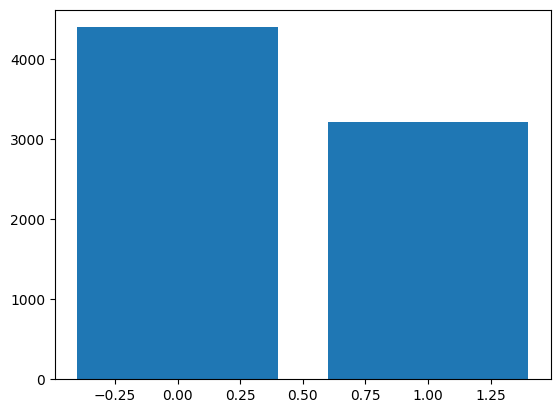

In [15]:
# Contar a quantidade de cada valor na coluna 'target'
counts = treino['target'].value_counts()

# Criar um gráfico de barras
plt.bar(counts.index, counts.values)

# Mostrar o gráfico
plt.show()

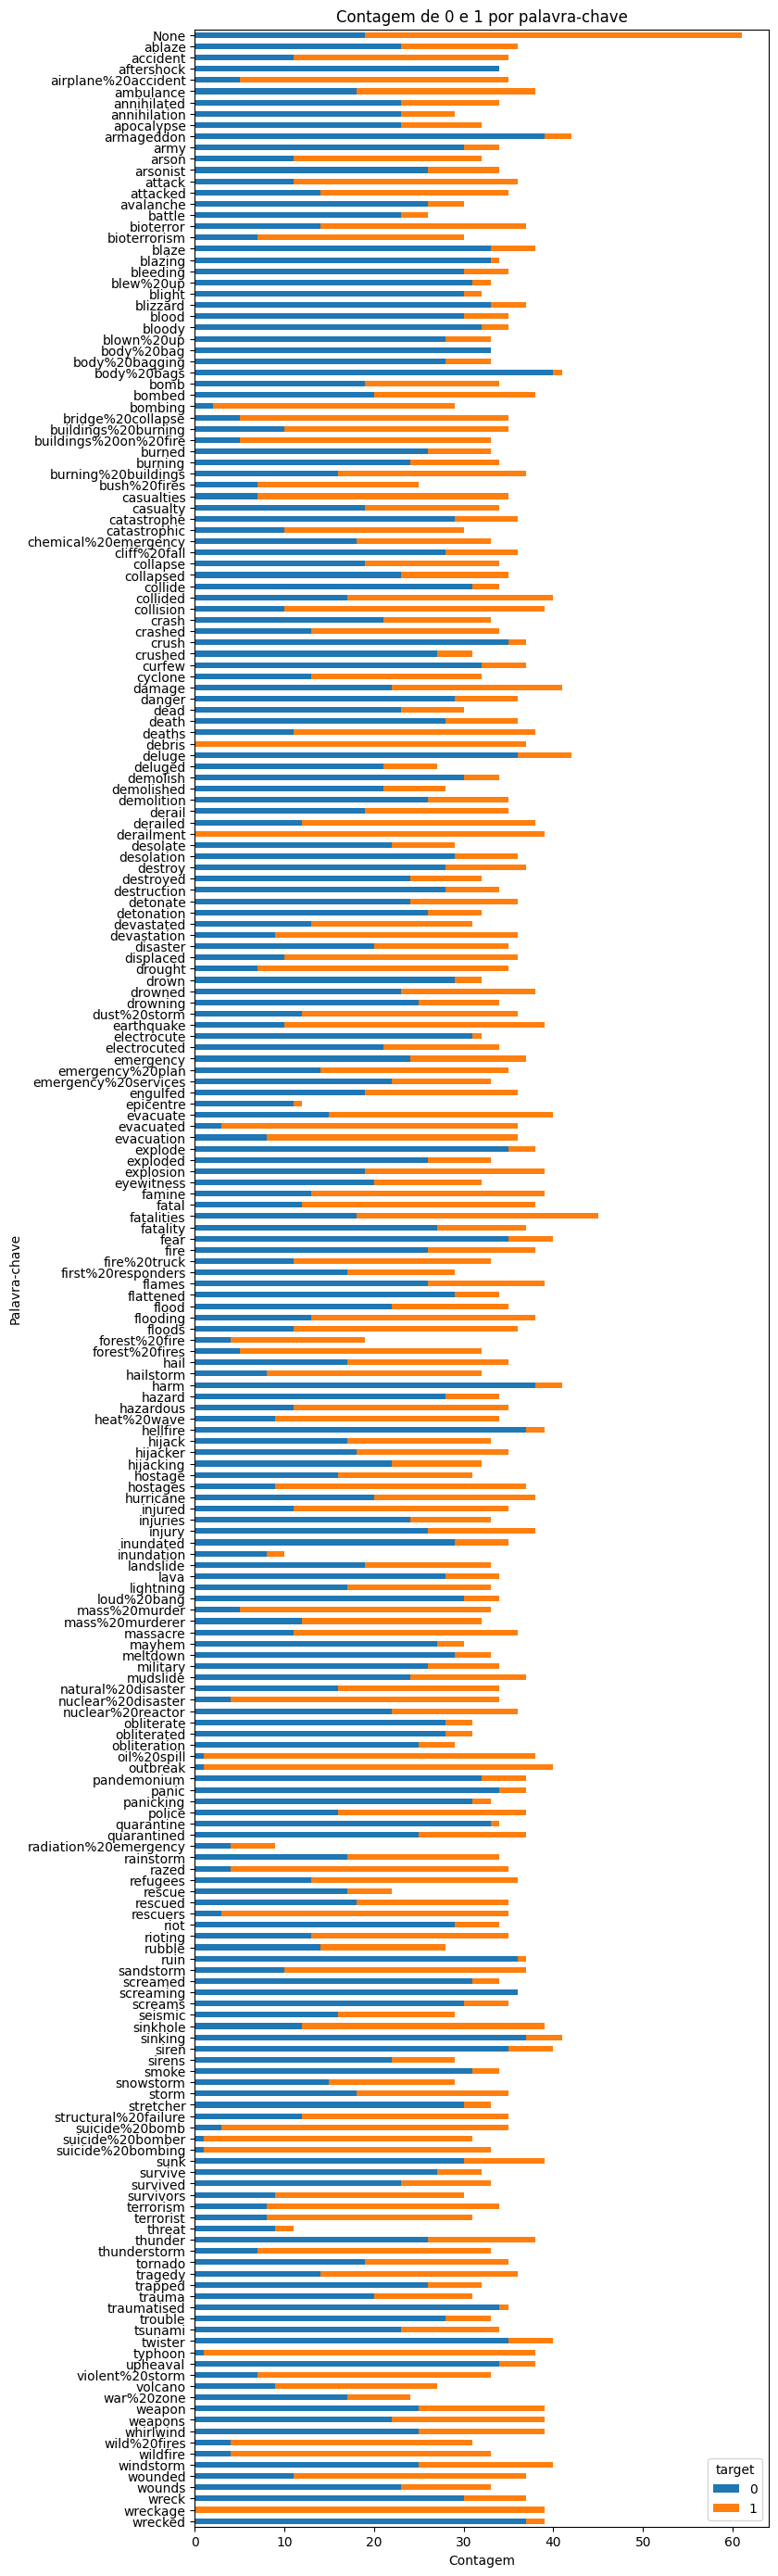

In [16]:
# Agrupar os dados por palavra-chave e contar a quantidade de ocorrências de 0 e 1
keyword_counts = treino.groupby('keyword')['target'].value_counts().unstack().fillna(0)

# Reverter a ordem das palavras-chave
keyword_counts = keyword_counts.reindex(index=keyword_counts.index[::-1])

# Configurar o tamanho da figura e dos eixos
fig, ax = plt.subplots(figsize=(8, 35))  # Ajuste os valores para aumentar ou diminuir a altura

# Plotar o gráfico de barras
keyword_counts.plot(kind='barh', stacked=True, ax=ax)

# Configurar o título e os rótulos dos eixos
ax.set_title('Contagem de 0 e 1 por palavra-chave')
ax.set_xlabel('Contagem')
ax.set_ylabel('Palavra-chave')

# Exibir o gráfico
plt.show()


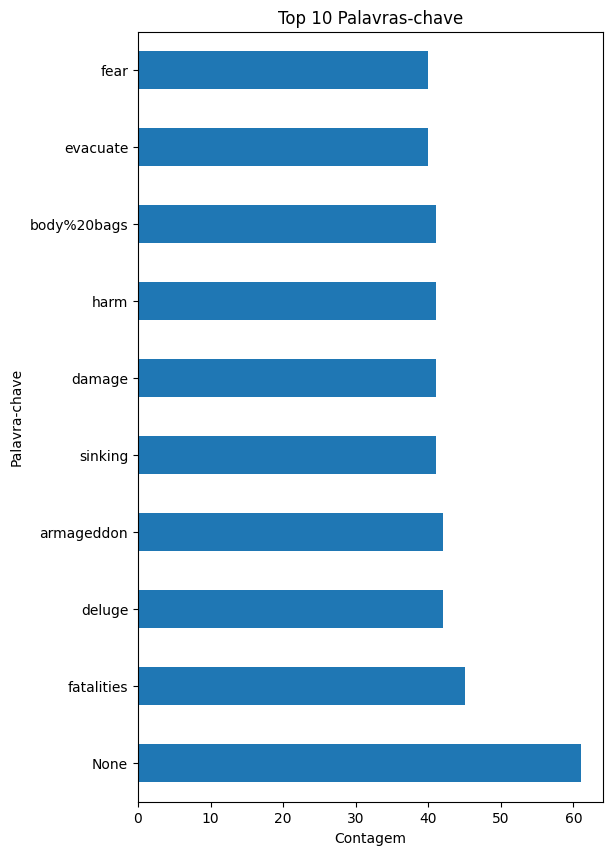

In [17]:
# Agrupar os dados por palavra-chave e contar a quantidade de ocorrências de 0 e 1
keyword_counts = treino['keyword'].value_counts().head(10)

# Configurar o tamanho da figura e dos eixos
fig, ax = plt.subplots(figsize=(6, 10))  # Ajuste os valores para controlar o tamanho do gráfico

# Plotar o gráfico de barras
keyword_counts.plot(kind='barh', ax=ax)

# Configurar o título e os rótulos dos eixos
ax.set_title('Top 10 Palavras-chave')
ax.set_xlabel('Contagem')
ax.set_ylabel('Palavra-chave')

# Exibir o gráfico
plt.show()


### Dados de treino e teste

In [18]:
X_train = treino[['text', 'keyword','location']]
y_train = treino['target']
X_test = teste[['text', 'keyword','location']]

In [19]:
X_train = X_train['text'] + '' + X_train['keyword']
X_test = X_test['text'] + '' + X_test['keyword']

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Utilizando BERT

In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# Carrega o tokenizer e o modelo pré-treinado do BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Define as configurações de preprocessamento, como o tamanho máximo da sequência
max_length = 128

# Pré-processa os dados de treinamento e teste
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length,
                            return_tensors='tf')
train_labels = y_train.tolist()

test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length,
                           return_tensors='tf')

val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=max_length,
                          return_tensors='tf')
val_labels = y_val.tolist()

# Converte os dados de treinamento em um objeto Dataset do TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(32)

# Função auxiliar para aplicar regularização L2 em uma camada
def apply_l2_regularization(layer, l2_factor):
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = tf.keras.regularizers.l2(l2_factor)
    if hasattr(layer, 'bias_regularizer'):
        layer.bias_regularizer = tf.keras.regularizers.l2(l2_factor)

# Aplica regularização L2 nas camadas relevantes do modelo BERT
for layer in model.layers:
    if 'attention' in layer.name or 'intermediate' in layer.name or 'output' in layer.name:
        apply_l2_regularization(layer, 0.0001)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Treinando o modelo

In [23]:
# Treina o modelo de classificação de sequências BERT com os dados de treinamento
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

# Faz as previsões no conjunto de teste
test_dataset = tf.data.Dataset.from_tensor_slices(dict(test_encodings)).batch(32)
y_pred = model.predict(test_dataset)

# Obtém as classes previstas
y_pred_classes = np.argmax(y_pred.logits, axis=1)

102/102 [==============================] - 11s 75ms/step


In [24]:
y_pred_classes

array([1, 1, 1, ..., 1, 1, 0])

In [25]:
len(y_pred_classes)

3263

In [26]:
# Cria um dataframe com a coluna 'Id' e a coluna 'y_pred'
output = pd.DataFrame({'id': teste['id'], 'target': y_pred_classes})

In [27]:
# Salva o dataframe em um arquivo csv
output.to_csv('submission.csv', index=False)